In [ ]:
j = 0
x = None
codes = []
return_mat = np.zeros((11602, 1271))
j = 0
for i in code_shares:
    price_matrix= sp_data[i].astype('float')
    price_matrix = np.array(price_matrix)
    returns = np.log(price_matrix[1:]) - np.log(price_matrix[0:-1])
    if np.where(returns<-5)[0].shape[0] == 0:
        codes.append(i)
        returns[np.isnan(returns)]=-5
        return_mat[:, j] = returns
        j += 1
df_return = pd.DataFrame(data=return_mat, columns=codes)
df_return.to_csv('returns127.csv')

In [1]:
import json
import mgarch
import os
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from cvxopt import matrix
from cvxopt.blas import dot 
from cvxopt import solvers
solvers.options['show_progress'] = False


def load_json(path):
    with open(path, 'rb') as f:
        json_dict = json.load(f)
    return json_dict


def find_first_800(sp_data_matrix, num):
    posts = []
    trading_days = sp_data_matrix.shape[0]
    for i in range(trading_days):
        num_eff = np.sum(sp_data_matrix[i, 2:]>-5)
        if num_eff == num:
            posts.append(i)
    return posts[0]


def get_sub_mat(df_return, st_idx, code_shares, sp_data, sam_size):
    indx_length = sam_size
    num_lim = indx_length + 21
    ed_idx = st_idx + num_lim
    code_ls = list(df_return.columns)[1:]
    code_used = []
    res_mat = []
    res_dict = {}
    res_pre_dict = {}
    market_cap_dict = {}
    for code_i in code_ls:
        res = df_return[code_i][st_idx:ed_idx]
        eff_num = np.sum(res>-5)
        if eff_num == num_lim:
            cap_i = code_shares[code_i] * sp_data[code_i][st_idx+indx_length]
            res_ls  = list(res)
            res_mat.append(res_ls[0:indx_length])
            code_used.append(code_i)
            res_dict[code_i] = res_ls[0:indx_length]
            res_pre_dict[code_i] = res_ls[indx_length:indx_length+21]
            market_cap_dict[code_i] = cap_i
    return res_mat, code_used, res_dict, res_pre_dict, market_cap_dict


def get_N(res_mat, code_used, res_dict, res_pre_dict, market_cap_dict, N):
    pos = np.where(np.corrcoef(np.array(res_mat))>0.95)
    if len(pos)>1:
        line_num, row_num = pos
        line_num = line_num.tolist()
        row_num = row_num.tolist()
        code_used_ori = copy.deepcopy(code_used)
        code_used = set(code_used)
        for i in range(len(line_num)):
            for j in range(len(row_num)):
                if  i > j:
                    stock_i = code_used_ori[line_num[i]]
                    stock_j = code_used_ori[row_num[j]]
                    cap_i = market_cap_dict[stock_i]
                    cap_j = market_cap_dict[stock_j]
            
                    if  cap_i>=cap_j and cap_i in code_used:
                        code_used.remove(stock_j)
                    elif cap_i<cap_j and cap_i in code_used:
                        code_used.remove(stock_i)
    
    code_cap = {}
    for code_i in code_used:
        code_cap[code_i] =  market_cap_dict[code_i]
        
    code_cap_sorted = sorted(code_cap.items(), key=lambda x: x[1], reverse=True)
    code_N = [i[0] for i in code_cap_sorted[0:N]]
    
    res_mat_new = []
    res_pre_new = []
    for code_i in code_N:
        res_mat_new.append(res_dict[code_i])
        res_pre_new.append(res_pre_dict[code_i])
    return res_mat_new, res_pre_new


def get_rolls(code_shares, sp_data, df_return, last_num, N, num, sam_size):
    st_id = find_first_800(df_return.to_numpy(), num)
    roll_len = sam_size+21
    j = 0
    all_rolls_res = 1
    while st_id+sam_size+21 <= last_num:
        res_mat, code_used, res_dict, res_pre_dict, market_cap_dict = get_sub_mat(df_return,
                                                st_id, code_shares, sp_data, sam_size)
        res_mat_new, res_pre_new = get_N(res_mat, code_used, 
                               res_dict, res_pre_dict, market_cap_dict, N)
        res_mat_new = np.array(res_mat_new).transpose()
        res_pre_new = np.array(res_pre_new).transpose()
        res_all = np.vstack((res_mat_new, res_pre_new))
        st_id += 21
        if all_rolls_res is  1:
            all_rolls_res = res_all
        else:
            all_rolls_res = np.vstack((all_rolls_res, res_all))
        
    return all_rolls_res


def get_return(weights, res_pre):
    weights = np.matrix(weights)
    res_pre = np.matrix(res_pre)
    return (weights*res_pre).tolist()[0]
    

def average_weights(n):
    return np.matrix([1/n for i in range(n)])


#def sample_cov_weights(res_mat):
#    cov = np.cov(np.array(res_mat))
#    N = cov.shape[0]
#    P = matrix(cov)
#    q = matrix(np.zeros((N, 1)))
#    G  = matrix(-np.identity(N))
#    h = matrix(np.zeros((N, 1)))
#    A = matrix(1.0, (1, N))
#    b = matrix(1.0)
#    sol = solvers.qp(P, q, G, h, A, b)
#    ws = np.matrix(sol['x']).T
#    return ws


def get_ws_cov(cov, no_short=True):
    if no_short:
        N = cov.shape[0]
        P = matrix(cov)
        q = matrix(np.zeros((N, 1)))
        G  = matrix(-np.identity(N))
        h = matrix(np.zeros((N, 1)))
        A = matrix(1.0, (1, N))
        b = matrix(1.0)
        sol = solvers.qp(P, q, G, h, A, b)
        ws = np.matrix(sol['x']).T
    else:
        cov_mat = np.matrix(cov)
        N = cov_mat.shape[0]
        I = np.matrix(np.ones(N)).T
        ws = (cov_mat.I * I)/(I.T*cov_mat.I*I)
        ws = ws.T
    return ws

#def sample_cov_weights(res_mat):
#    cov = np.cov(np.array(res_mat))
#    cov_mat = np.matrix(cov)
#    N = cov.shape[0]
#    I = np.matrix(np.ones(N)).T
#    ws = (cov_mat.I * I)/(I.T*cov_mat.I*I)
#    return ws.T


#def get_ws_cov(cov_mat):
#    cov_mat = np.matrix(cov_mat)
#    N = cov_mat.shape[0]
#    I = np.matrix(np.ones(N)).T
#    ws = (cov_mat.I * I)/(I.T*cov_mat.I*I)
#    return ws.T    


def get_sam_res(code_shares, sp_data, df_return, last_num, N, num, sam_size):
    st_id = find_first_800(df_return.to_numpy(), num)
    res_ew = []
    res_sample_cov = []
    while st_id + sam_size+21 <= last_num:
        res_mat, code_used, res_dict, res_pre_dict, market_cap_dict = get_sub_mat(df_return,
                                                                st_id, code_shares, sp_data, sam_size)
        res_mat_new, res_pre_new = get_N(res_mat, code_used, 
                               res_dict, res_pre_dict, market_cap_dict, N)
        st_id += 21
        avg_ws = average_weights(N)
        avg_res_i = get_return(avg_ws, res_pre_new)
        res_ew += avg_res_i
        sam_cov = np.cov(np.array(res_mat_new))
        samp_ws = get_ws_cov(sam_cov, no_short=False)
        sam_res_i = get_return(samp_ws,  res_pre_new)
        res_sample_cov += sam_res_i
    return res_ew, res_sample_cov


def indicators(res):
    AV= round(np.mean(res)*252*100, 5)
    SD = round(np.cov(res)**0.5*252**0.5*100, 5)
    IR = round(AV/SD, 5)
    return AV, SD, IR


def read_dcc_res(path):
    res_dccnl = pd.read_csv(path)
    res_dccnl= res_dccnl['x']
    res_dccnl = list(res_dccnl)
    return res_dccnl

def res_line(res):
    portfolio_res = [1]
    a = 1
    for i in res:
        a = a*(1+i)
        portfolio_res.append(a)
    return portfolio_res

def get_dcc_res1(root_dir, rolls, N, no_short):
    file_ls = os.listdir(root_dir)
    length = len(file_ls)
    res_dccnl = []
    for i in range(length):
        file_path = os.path.join(root_dir, '{}.csv'.format(i+1))
        cov_mat = pd.read_csv(file_path)
        cov_mat = np.matrix(cov_mat.to_numpy())
        #st_idx = i*1281
        #ed_idx = i*1281+1260
        #res_mat = rolls[st_idx:ed_idx, 1:N+1]
        #cov_mat =  np.cov(np.array(res_mat).transpose())
        ws_i = get_ws_cov(cov_mat, no_short=no_short)
        st_idx = (i+1)*1281-21
        ed_idx = (i+1)*1281
        res_pre_i = rolls[st_idx:ed_idx, 1:N+1]
        res_pre_i = np.matrix(res_pre_i).T
        res_i = get_return(ws_i, res_pre_i)
        res_dccnl += res_i
    return res_dccnl

# 1 load_data and get return rates

In [2]:
code_shares = load_json('./code_shares.json')
sp_data = pd.read_csv('./SP1273_19750103_20201231.csv')
df_return = pd.read_csv('./returns1271.csv')

# 2 get all rolling res data

In [ ]:
all_rolls_res = get_rolls(code_shares, sp_data, df_return, 11602, 500, 800, 630)

In [315]:
all_rolls_res1 = np.around(all_rolls_res, decimals=6, out=None)
col_names = []
for i in range(500):
    col_names.append('asset{}'.format(i))
df_rolls = pd.DataFrame(data=all_rolls_res1, columns=col_names)
df_rolls.to_csv('df_rolls_500_630.csv')

# 3 get portfolio universe

In [3]:
rolls = pd.read_csv('./df_rolls.csv')
rolls = rolls.to_numpy()

# N=100

In [4]:
avg_res_100, samp_res_100 = get_sam_res(code_shares, sp_data, df_return, 11602, 100, 800, 1260)

In [5]:
root_dir = './cov_100_dcc/'
res_dccnl_100 = get_dcc_res1(root_dir, rolls, 100, no_short=False)

In [6]:
AV_avg, SD_avg, IR_avg = indicators(avg_res_100)
AV_sam, SD_sam, IR_sam = indicators(samp_res_100)
AV_DCCNL, SD_DCCNL, IR_DCCNL = indicators(res_dccnl_100)
print('|','1/N', AV_avg, '|', SD_avg, '|', IR_avg, '|')
print('|','sample', AV_sam, '|', SD_sam, '|', IR_sam,'|')
print('|', 'DCCNL', AV_DCCNL, '|', SD_DCCNL, '|', IR_DCCNL,'|')

| 1/N 5.19048 | 20.65605 | 0.25128 |
| sample -692.8167 | 3127.03814 | -0.22156 |
| DCCNL 7.42985 | 13.78978 | 0.53879 |


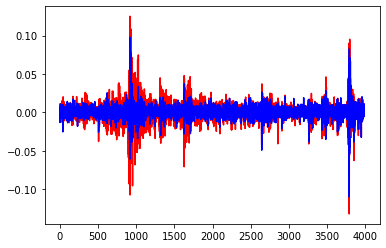

In [8]:
plt.plot(avg_res_100, 'r')
#plt.plot(samp_res_100, 'g')
plt.plot(res_dccnl_100, 'b')

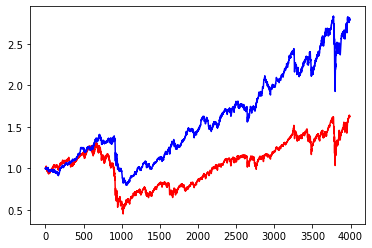

In [10]:
avg_res_100_line = res_line(avg_res_100)
sam_res_100_line = res_line(samp_res_100)
res_dccnl_100_line = res_line(res_dccnl_100)
plt.plot(avg_res_100_line, 'r')
#plt.plot(sam_res_100_line, 'g')
plt.plot(res_dccnl_100_line, 'b')

# N = 200

In [12]:
avg_res_200, samp_res_200 = get_sam_res(code_shares, sp_data, df_return, 11602, 200, 800, 1260)

In [13]:
root_dir = './cov_200_dcc/'
res_dccnl_200 = get_dcc_res1(root_dir, rolls, 200, no_short=False)

In [14]:
AV_avg, SD_avg, IR_avg = indicators(avg_res_200)
AV_sam, SD_sam, IR_sam = indicators(samp_res_200)
AV_DCCNL, SD_DCCNL, IR_DCCNL = indicators(res_dccnl_200)
print('|','1/N', AV_avg, '|', SD_avg, '|', IR_avg, '|')
print('|','sample', AV_sam, '|', SD_sam, '|', IR_sam,'|')
print('|', 'DCCNL', AV_DCCNL, '|', SD_DCCNL, '|', IR_DCCNL,'|')

| 1/N 5.58737 | 20.94381 | 0.26678 |
| sample -550.53041 | 2487.3752 | -0.22133 |
| DCCNL 9.77188 | 12.96225 | 0.75387 |


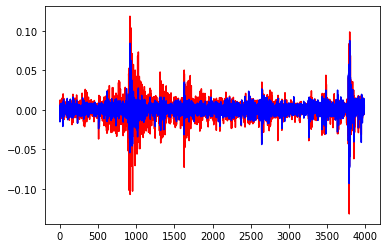

In [16]:
#samp_res_200[2289:2310] = [0 for i in range(21)]
plt.plot(avg_res_200, 'r')
#plt.plot(samp_res_200, 'g')
plt.plot(res_dccnl_200, 'b')

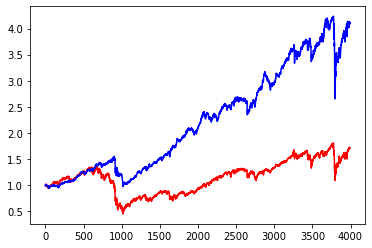

In [17]:
avg_res_200_line = res_line(avg_res_200)
sam_res_200_line = res_line(samp_res_200)
res_dccnl_200_line = res_line(res_dccnl_200)
plt.plot(avg_res_200_line, 'r')
#plt.plot(sam_res_200_line, 'g')
plt.plot(res_dccnl_200_line, 'b')